# 6314 Group Assignment Part 1


# ETL Process

## Load Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Bike Data

In [3]:
# read csv files
df_Feb=pd.read_csv("/content/drive/MyDrive/ml/202302-captialbikeshare-tripdata.csv") # Note: a different path name
df_Mar=pd.read_csv("/content/drive/MyDrive/ml/202303-capitalbikeshare-tripdata.csv")
df_Apr=pd.read_csv("/content/drive/MyDrive/ml/202304-capitalbikeshare-tripdata.csv")
df_May=pd.read_csv("/content/drive/MyDrive/ml/202305-capitalbikeshare-tripdata.csv")
df_Jun=pd.read_csv("/content/drive/MyDrive/ml/202306-capitalbikeshare-tripdata.csv")

## Import Weather Data

In [4]:
df_weather = pd.read_csv("/content/drive/MyDrive/ml/washington, dc 2023-01-01 to 2023-12-31.csv")


# Drop unnecessary variables
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])
df_weather.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,2023-01-01,61.4,43.5,51.8,61.4,41.7,51.2,46.2,82.2,0.004,...,8.8,199.3,1015.4,47.7,9.1,100.5,8.7,4,0.32,rain
1,2023-01-02,63.0,40.0,50.9,63.0,36.3,50.2,44.2,79.3,0.000,...,9.1,190.8,1019.8,87.8,9.8,65.3,5.7,4,0.35,partly-cloudy-day
2,2023-01-03,68.0,50.1,59.3,68.0,50.1,59.3,52.3,78.5,0.000,...,17.7,196.2,1014.1,90.8,9.7,38.6,3.4,2,0.39,cloudy
3,2023-01-04,65.0,53.3,59.5,65.0,53.3,59.5,55.0,85.4,0.000,...,14.1,194.4,1010.4,85.2,9.9,32.2,2.8,2,0.42,partly-cloudy-day
4,2023-01-05,64.0,49.6,56.4,64.0,45.1,55.9,46.0,70.4,0.000,...,12.6,231.5,1013.3,75.8,9.9,71.1,6.0,4,0.46,partly-cloudy-day


## Data Wrangling

In [5]:
# concat data
df=pd.concat([df_Feb,df_Mar,df_Apr,df_May,df_Jun])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749886 entries, 0 to 430669
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    float64
 6   end_station_name    object 
 7   end_station_id      float64
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(6), object(7)
memory usage: 186.9+ MB


In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6D7F3F3DDD864A41,classic_bike,2023-02-04 21:08:26,2023-02-04 21:16:39,New Jersey Ave & N St NW/Dunbar HS,31636.0,8th & V St NW,31134.0,38.907333,-77.015360,38.917716,-77.022684,member
1,1B4FD92511BA8869,classic_bike,2023-02-28 18:24:01,2023-02-28 18:28:46,11th & Girard St NW,31126.0,8th & V St NW,31134.0,38.925636,-77.027112,38.917716,-77.022684,member
2,E215D5A904EC376F,classic_bike,2023-02-12 14:03:48,2023-02-12 14:05:44,3rd & H St NW,31604.0,1st & H St NW,31638.0,38.899408,-77.015289,38.900358,-77.012108,member
3,AF176FEC3204AEB5,classic_bike,2023-02-08 19:25:13,2023-02-08 19:33:08,7th St & Florida Ave NW,31109.0,7th & F St NW / National Portrait Gallery,31232.0,38.916137,-77.022003,38.897283,-77.022191,member
4,CB8BE52EB8F58E80,classic_bike,2023-02-27 14:48:59,2023-02-27 14:54:10,8th & V St NW,31134.0,8th & V St NW,31134.0,38.917716,-77.022684,38.917716,-77.022684,member


In [7]:
# Transform time to date ONLY
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

### Count daily pickups

In [8]:
# Group and get pickup occurrence for 22nd & H St NW
df_sub1 = df[df['start_station_name']=="22nd & H St NW"]
df_grp1 = df_sub1.groupby(['started_at_date','start_station_name']).size()
df_pu=df_grp1.reset_index(name = "pu_ct")
df_pu

,started_at_date,start_station_name,pu_ct
0,2023-02-01,22nd & H St NW,20
1,2023-02-02,22nd & H St NW,26
2,2023-02-03,22nd & H St NW,14
3,2023-02-04,22nd & H St NW,12
4,2023-02-05,22nd & H St NW,17
...,...,...,...
145,2023-06-26,22nd & H St NW,21
146,2023-06-27,22nd & H St NW,20
147,2023-06-28,22nd & H St NW,26
148,2023-06-29,22nd & H St NW,32


### Count daily dropoffs

In [9]:
# Group and get drop off occurrence for 22nd & H St NW
df_sub2 = df[df['end_station_name']=="22nd & H St NW"]
df_grp2 = df_sub2.groupby(['ended_at_date','end_station_name']).size()
df_do=df_grp2.reset_index(name = "do_ct")
df_do

,ended_at_date,end_station_name,do_ct
0,2023-02-01,22nd & H St NW,24
1,2023-02-02,22nd & H St NW,28
2,2023-02-03,22nd & H St NW,17
3,2023-02-04,22nd & H St NW,13
4,2023-02-05,22nd & H St NW,24
...,...,...,...
145,2023-06-26,22nd & H St NW,18
146,2023-06-27,22nd & H St NW,21
147,2023-06-28,22nd & H St NW,26
148,2023-06-29,22nd & H St NW,43


### Merge with weather data and remove dates and station name

In [10]:
# Merge with weather data and remove dates and station name
# pickup data
df_m_pu = df_pu.merge(df_weather, left_on='started_at_date', right_on='datetime')
df_m_pu = df_m_pu.drop(columns=['started_at_date','start_station_name','datetime'])


df_m_pu.head()

,pu_ct,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,20,40.7,32.5,35.6,37.4,23.9,29.1,21.6,59.4,0.043,...,15.3,347.8,1025.5,81.8,9.1,130.3,11.2,6,0.36,snow
1,26,41.8,31.3,36.0,36.8,28.1,32.2,22.5,59.2,0.000,...,11.3,199.9,1021.8,94.5,9.9,87.7,7.5,4,0.40,cloudy
2,14,40.7,19.8,31.7,34.1,4.3,20.7,10.5,43.4,0.000,...,28.1,317.1,1021.4,54.6,9.9,143.9,12.5,6,0.43,partly-cloudy-day
3,12,31.9,16.9,24.5,23.0,2.6,15.1,2.1,37.9,0.000,...,16.9,221.9,1035.2,27.8,9.9,150.7,13.1,6,0.46,partly-cloudy-day
4,17,58.8,33.0,44.2,58.8,22.9,39.9,22.3,42.6,0.000,...,17.9,195.8,1022.1,79.7,9.9,116.1,9.9,5,0.50,partly-cloudy-day


In [11]:
# dropoff data
df_m_do = df_do.merge(df_weather, left_on='ended_at_date', right_on='datetime')
df_m_do = df_m_do.drop(columns=['ended_at_date','end_station_name','datetime'])
df_m_do.head()

,do_ct,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,24,40.7,32.5,35.6,37.4,23.9,29.1,21.6,59.4,0.043,...,15.3,347.8,1025.5,81.8,9.1,130.3,11.2,6,0.36,snow
1,28,41.8,31.3,36.0,36.8,28.1,32.2,22.5,59.2,0.000,...,11.3,199.9,1021.8,94.5,9.9,87.7,7.5,4,0.40,cloudy
2,17,40.7,19.8,31.7,34.1,4.3,20.7,10.5,43.4,0.000,...,28.1,317.1,1021.4,54.6,9.9,143.9,12.5,6,0.43,partly-cloudy-day
3,13,31.9,16.9,24.5,23.0,2.6,15.1,2.1,37.9,0.000,...,16.9,221.9,1035.2,27.8,9.9,150.7,13.1,6,0.46,partly-cloudy-day
4,24,58.8,33.0,44.2,58.8,22.9,39.9,22.3,42.6,0.000,...,17.9,195.8,1022.1,79.7,9.9,116.1,9.9,5,0.50,partly-cloudy-day


# Exploratory Analysis

### Scatter Plot for Pickup Count and Various Independent Variables

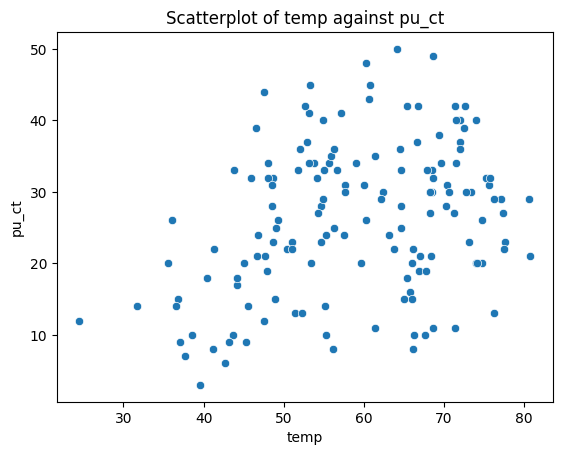

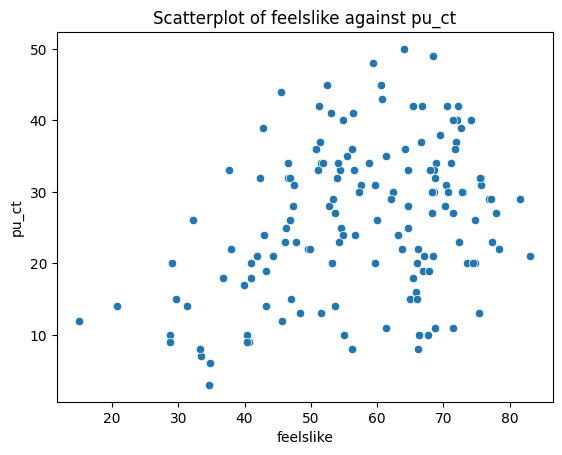

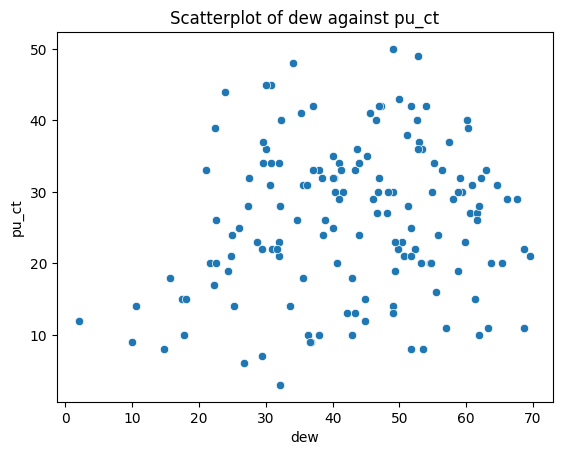

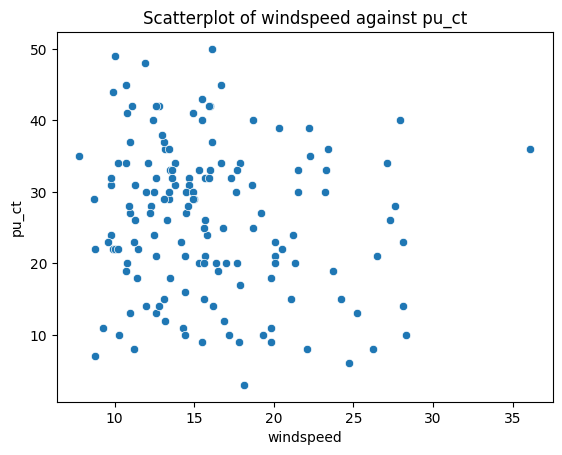

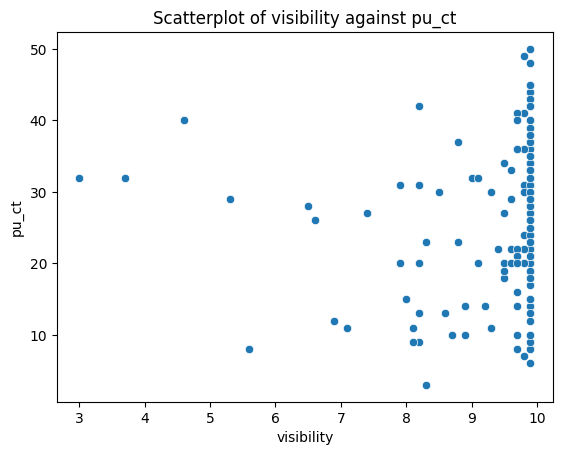

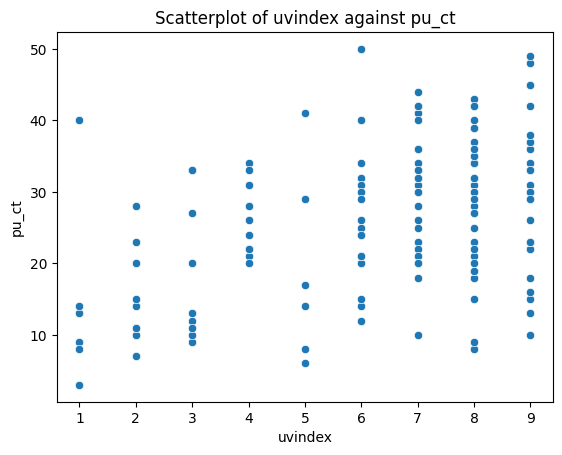

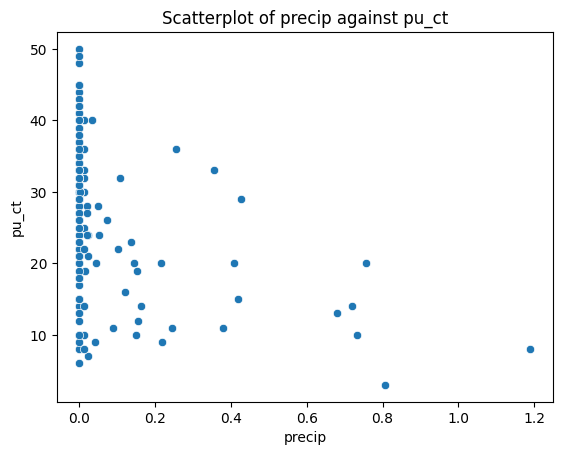

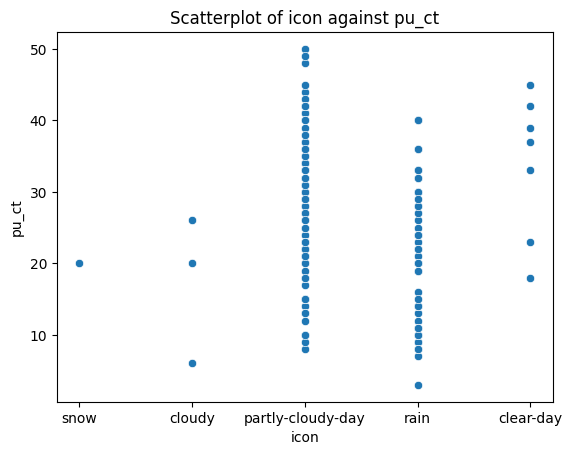

In [12]:

# Select target variable
target_variable = 'pu_ct'

# Select independent variables
selected_columns = ['temp', 'feelslike','dew','windspeed','visibility','uvindex','precip','icon']

# Create scatter plots for each independent variable against the target variable
for i in selected_columns:
    sns.scatterplot(x=i, y=target_variable, data=df_m_pu)
    plt.xlabel(i)
    plt.ylabel(target_variable)
    plt.title(f'Scatterplot of {i} against {target_variable}')
    plt.show()


### Scatter Plot for Dropoff Count and Various Independent Variables

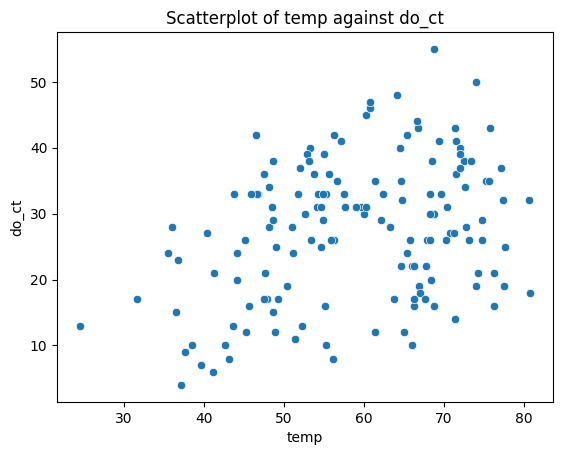

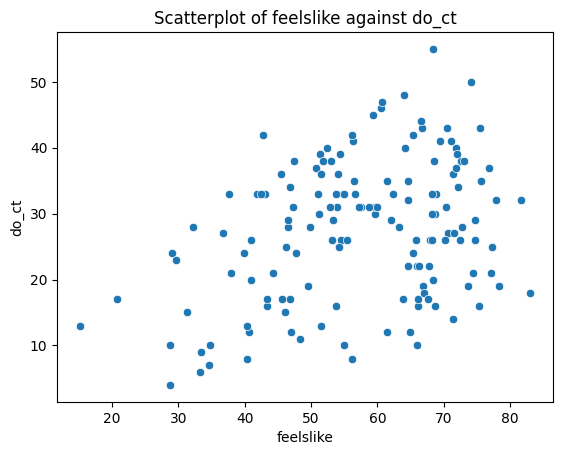

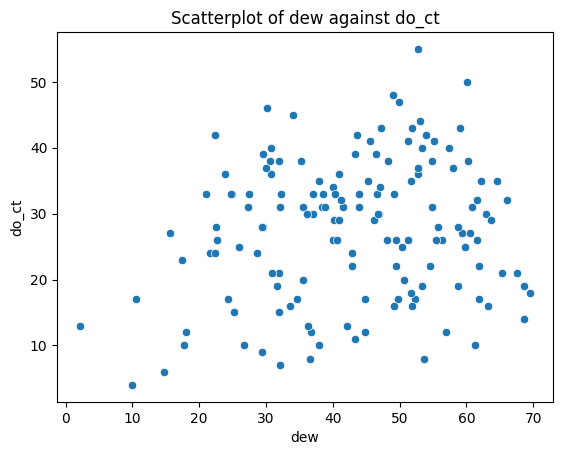

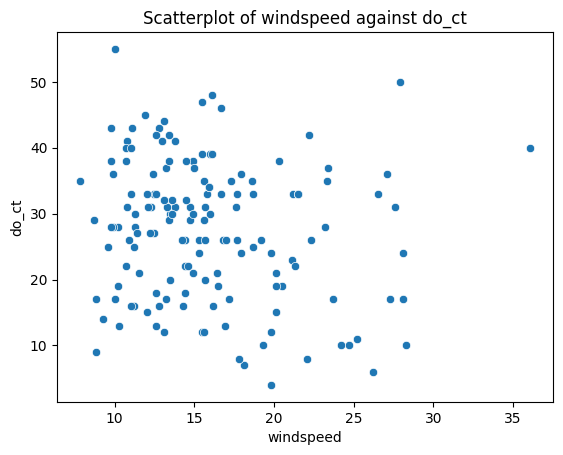

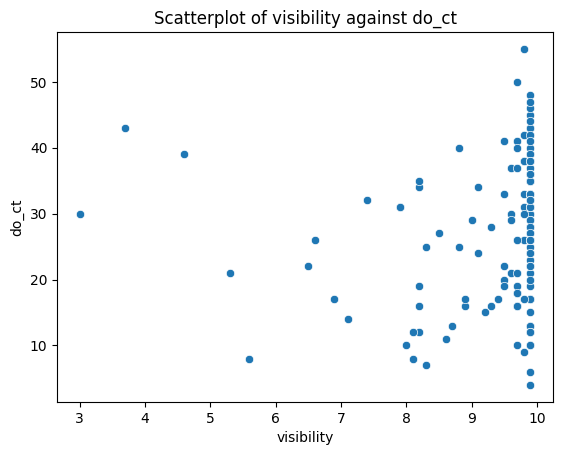

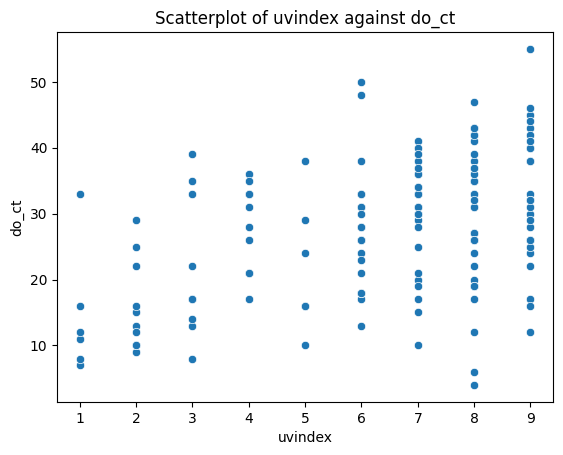

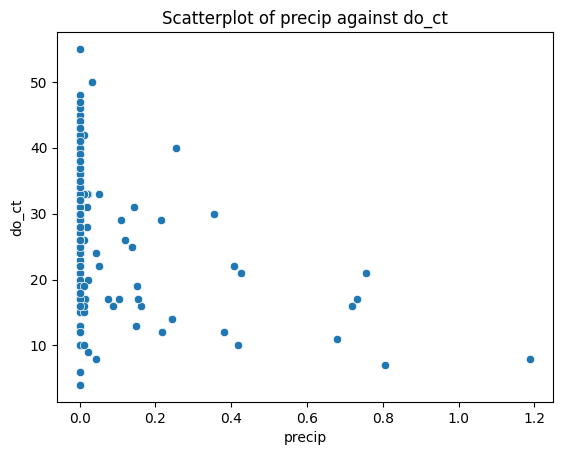

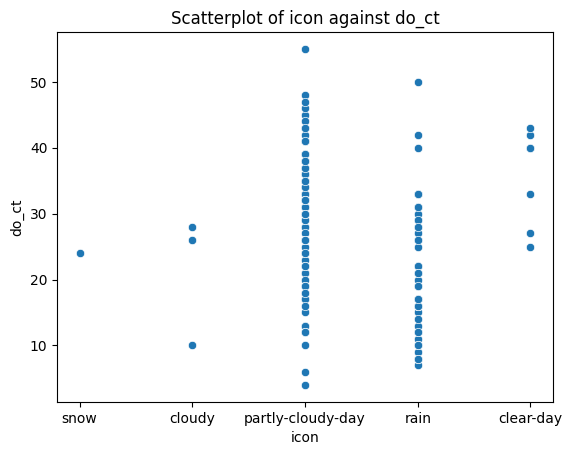

In [13]:
# Select target variable
target_variable = 'do_ct'

# Select independent variables
selected_columns = ['temp', 'feelslike','dew','windspeed','visibility','uvindex','precip','icon']

# Create scatter plots for each independent variable against the target variable
for i in selected_columns:
    sns.scatterplot(x=i, y=target_variable, data=df_m_do)
    plt.xlabel(i)
    plt.ylabel(target_variable)
    plt.title(f'Scatterplot of {i} against {target_variable}')
    plt.show()

# Linear Regression Model

## Prepare training data

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [15]:
merged_df = pd.merge(df_m_pu, df_m_do, on=['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'moonphase', 'icon'], how='inner')

In [16]:
col_drop = ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'precipprob', 'precipcover',
       'snow', 'snowdepth','winddir', 'sealevelpressure',
       'cloudcover','solarradiation', 'solarenergy',
       'moonphase']

In [17]:
merged_df = merged_df.drop(columns = col_drop, axis = 1)
merged_df.head()

,pu_ct,temp,feelslike,dew,humidity,precip,windspeed,visibility,uvindex,icon,do_ct
0,20,35.6,29.1,21.6,59.4,0.043,15.3,9.1,6,snow,24
1,26,36.0,32.2,22.5,59.2,0.000,11.3,9.9,4,cloudy,28
2,14,31.7,20.7,10.5,43.4,0.000,28.1,9.9,6,partly-cloudy-day,17
3,12,24.5,15.1,2.1,37.9,0.000,16.9,9.9,6,partly-cloudy-day,13
4,17,44.2,39.9,22.3,42.6,0.000,17.9,9.9,5,partly-cloudy-day,24


In [18]:
from sklearn.model_selection import train_test_split
X = merged_df.drop('pu_ct',axis=1)
X = X.drop('do_ct',axis=1)

y = pd.DataFrame()
y['pu_ct']=merged_df['pu_ct']
y['do_ct']=merged_df['do_ct']
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4)

In [19]:
# pickup
keep = ['pu_ct','temp', 'feelslike','precip','dew','windspeed','visibility','uvindex','icon']
pu = df_m_pu[keep]

y = pu['pu_ct']
X = pu.drop('pu_ct',axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X.head()

y = pd.DataFrame()
y['pu_ct']=df_m_pu['pu_ct']
y['do_ct']=df_m_do['do_ct']
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4)

## Split into training and test

In [20]:
# 60% test data
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.6, random_state = 200)

In [21]:
X_train.columns

Index(['temp', 'feelslike', 'precip', 'dew', 'windspeed', 'visibility',
       'uvindex', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'icon_snow'],
      dtype='object')

## MSE for Pickup Plot Training Data and Testing Data

[98.90073005589508, 91.06432832003094, 76.49699131617544, 74.44350406508653, 73.98118361488781, 71.95646416108747, 67.50334152221751, 67.2825572398448, 66.91861925118329, 57.78169500556969, 56.87488083662946]
[101.72657442204168, 95.4756333310736, 77.13237946473242, 72.1453861565847, 71.98164665777996, 81.08621096181761, 75.46514864675626, 75.81406733973085, 76.61249147618295, 79.11327396782727, 81.48810964258617]


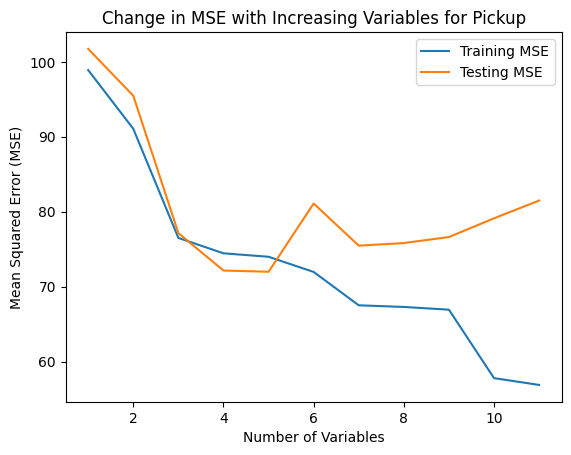

In [22]:
train_mses = []
test_mses = []
num_features = []
for i in range(1, X_train.shape[1] + 1):
    # Select the first i features
    selected_features = X_train.columns[:i]

    # Create a linear regression model
    model = LinearRegression()

    # Train the model on the training data
    model.fit(X_train[selected_features], y_train)

    # Make predictions on training and testing sets
    train_predictions = model.predict(X_train[selected_features])
    test_predictions = model.predict(X_test[selected_features])

    # Calculate MSEs
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Append MSEs and number of features to the lists
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    num_features.append(i)

print(train_mses)
print(test_mses)


# Plot the changes in training and test MSEs
plt.plot(num_features, train_mses, label='Training MSE')
plt.plot(num_features, test_mses, label='Testing MSE')
plt.xlabel('Number of Variables')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Change in MSE with Increasing Variables for Pickup')
plt.legend()
plt.show()

In [23]:
#MSE
linear_pu_mse = min(test_mses)
print(linear_pu_mse)

#R2
linear_r2_pu = round(r2_score(y_test, test_predictions), 3)
print(f"R2 in pickup test data for LR is {linear_r2_pu}")

71.98164665777996
R2 in pickup test data for LR is 0.274


As more independent variables are introduced, we can see that the mean squared error for the training set is decreasing. However, we can see that for the testing set, the MSE first decreases until the 5th variable is introduced and then increase for the rest.

BEST TEST MSE FOR PICKUP = 71.981646

## MSE for Dropoff Plot Training Data and Testing Data

In [24]:
keep = ['do_ct','temp', 'feelslike','precip','dew','windspeed','visibility','uvindex','icon']
do = df_m_do[keep]

y = do['do_ct']
X = do.drop('do_ct',axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,temp,feelslike,precip,dew,windspeed,visibility,uvindex,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow
0,35.6,29.1,0.043,21.6,15.3,9.1,6,0,0,0,1
1,36.0,32.2,0.000,22.5,11.3,9.9,4,1,0,0,0
2,31.7,20.7,0.000,10.5,28.1,9.9,6,0,1,0,0
3,24.5,15.1,0.000,2.1,16.9,9.9,6,0,1,0,0
4,44.2,39.9,0.000,22.3,17.9,9.9,5,0,1,0,0


In [25]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.6, random_state = 200)
X_train.columns

Index(['temp', 'feelslike', 'precip', 'dew', 'windspeed', 'visibility',
       'uvindex', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'icon_snow'],
      dtype='object')

[99.62485198711123, 92.64963820159964, 78.61127010054152, 77.28507507330202, 77.27974012835118, 75.0912687122709, 72.2335183865063, 72.22929908490549, 71.97367537259298, 63.60809128386272, 63.32057596844472]
[98.95611832966824, 94.80096982300118, 76.25290374529385, 72.1160261029176, 72.24029364074799, 80.04251782521067, 74.32929826865535, 74.40291086538153, 74.74387442101045, 75.73705795099772, 76.60869315987999]


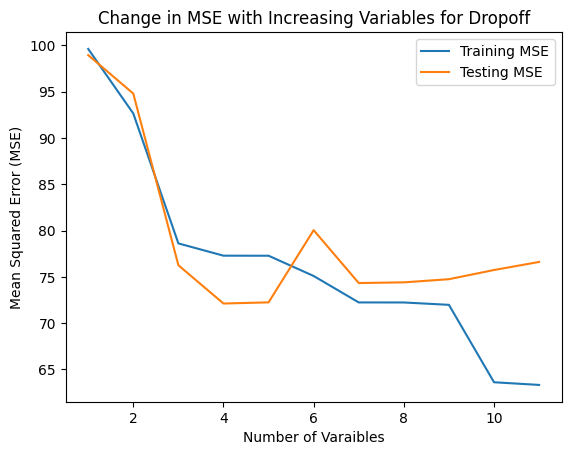

In [26]:
train_mses = []
test_mses = []
num_features = []
for i in range(1, X_train.shape[1] + 1):
    # Select the first i features
    selected_features = X_train.columns[:i]

    # Create a linear regression model
    model = LinearRegression()

    # Train the model on the training data
    model.fit(X_train[selected_features], y_train)

    # Make predictions on training and testing sets
    train_predictions = model.predict(X_train[selected_features])
    test_predictions = model.predict(X_test[selected_features])

    # Calculate MSEs
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Append MSEs and number of features to the lists
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    num_features.append(i)

print(train_mses)
print(test_mses)
# Plot the changes in training and test MSEs
plt.plot(num_features, train_mses, label='Training MSE')
plt.plot(num_features, test_mses, label='Testing MSE')
plt.xlabel('Number of Varaibles')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Change in MSE with Increasing Variables for Dropoff')
plt.legend()
plt.show()


In [27]:
#MSE
linear_do_mse = min(test_mses)
print(linear_do_mse)

#R2
linear_r2_do = round(r2_score(y_test, test_predictions), 3)
print(f"R2 in dropoff test data for LR is {linear_r2_do}")

72.1160261029176
R2 in dropoff test data for LR is 0.307


BEST TEST MSE FOR DROPOFF = 72.116026

In [28]:
# Assuming df_m_pu and df_m_do are your processed DataFrames for pickup and dropoff
# Define features and target for pickup
features_pu =['temp', 'feelslike','dew','precip','windspeed']
target_pu = 'pu_ct'

# Define features and target for dropoff
features_do =  ['temp', 'feelslike','precip','dew']
target_do = 'do_ct'

# Select data for pickup and dropoff
data_pu = df_m_pu[features_pu + [target_pu]]
data_do = df_m_do[features_do + [target_do]]

# Split data for pickup and dropoff into features (X) and target variable (y)
X_train_pu, X_test_pu, y_train_pu, y_test_pu = train_test_split(data_pu[features_pu], data_pu[target_pu], test_size=0.6, random_state=200)
X_train_do, X_test_do, y_train_do, y_test_do = train_test_split(data_do[features_do], data_do[target_do], test_size=0.6, random_state=200)

# Create linear regression models for pickup and dropoff
model_pu = LinearRegression()
model_do = LinearRegression()

# Train models for pickup and dropoff
model_pu.fit(X_train_pu, y_train_pu)
model_do.fit(X_train_do, y_train_do)


print('The coefficients for Pickup are:')
print(pd.Series(model_pu.coef_.flatten(), index=X_train_pu.columns))

print('The coefficients for Dropoff are:')
print(pd.Series(model_do.coef_.flatten(), index=X_train_do.columns))


The coefficients for Pickup are:
temp         -2.935983
feelslike     2.964027
dew          -0.288354
precip      -17.173395
windspeed     0.197486
dtype: float64
The coefficients for Dropoff are:
temp         -2.307271
feelslike     2.428412
precip      -16.486325
dew          -0.227637
dtype: float64


**RIDGE REGRESSION**




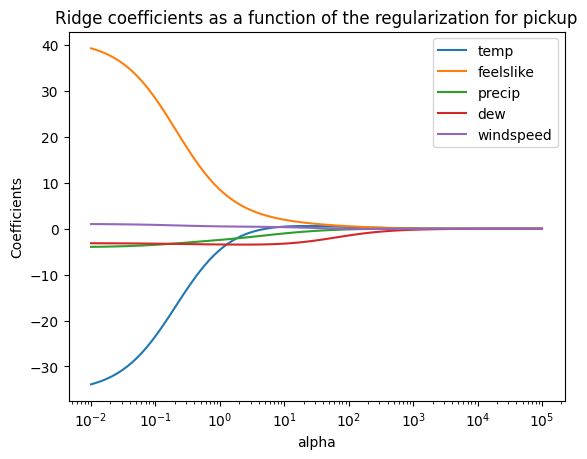

In [29]:
#pickup
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train_pu), y_train_pu)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization for pickup');



Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization for dropoff')

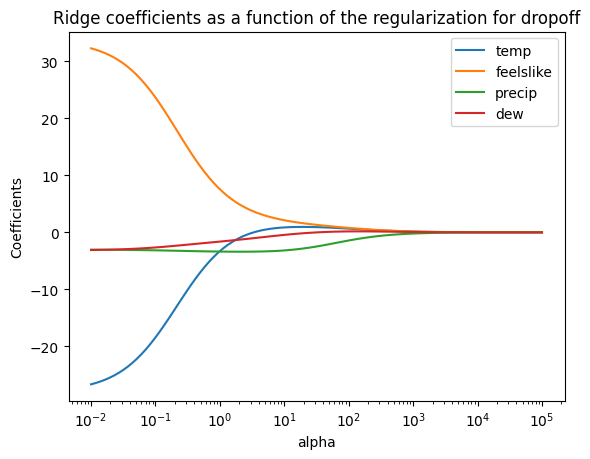

In [30]:
#dropoff
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train_do), y_train_do)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization for dropoff')

In [31]:
#pickup
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_pu)
ridgecv1 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv1.fit(scale(X_train_pu), y_train_pu)

print('The best alpha from RidgeCV:', ridgecv1.alpha_)

ridge.set_params(alpha=ridgecv1.alpha_)
ridge.fit(scale(X_train_pu), y_train_pu)
print('The coefficients with the best alpha for pickup are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train_pu.columns))

The best alpha from RidgeCV: 0.01
The coefficients with the best alpha for pickup are:
temp        -33.886615
feelslike    39.295520
dew          -3.944522
precip       -3.159903
windspeed     1.019275
dtype: float64


In [32]:
#pickup
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_test_pu)
ridgecv1 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv1.fit(scale(X_test_pu), y_test_pu)

print('The best alpha from RidgeCV:', ridgecv1.alpha_)

ridge.set_params(alpha=ridgecv1.alpha_)
ridge.fit(scale(X_test_pu), y_test_pu)
print('The coefficients with the best alpha for pickup are:')
print(pd.Series(ridge.coef_.flatten(), index=X_test_pu.columns))

The best alpha from RidgeCV: 0.0509413801481638
The coefficients with the best alpha for pickup are:
temp        -20.853850
feelslike    31.308314
dew          -6.252302
precip       -2.873865
windspeed     0.322483
dtype: float64


In [33]:
#PICKUP
# Assuming scaler is already fitted to your training data as shown in your snippet
X_test_pu_scaled = scaler.transform(X_test_pu)

# Making predictions using the trained Ridge model
y_pred_pu = ridge.predict(X_test_pu_scaled)

# Calculating MSE
ridge_mse_pu = mean_squared_error(y_test_pu, y_pred_pu)
print("Test MSE for Ridge model:", ridge_mse_pu)

ridge_r2_pu = r2_score(y_test_pu, y_pred_pu)
print("Test R-squared:", ridge_r2_pu)


Test MSE for Ridge model: 63.42594234151027
Test R-squared: 0.44313818194149546


In [34]:
_#Dropoff
scaler = StandardScaler().fit(X_train_do)
ridgecv2 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv2.fit(scale(X_train_do), y_train_do)

print('The best alpha from RidgeCV:', ridgecv2.alpha_)

ridge.set_params(alpha=ridgecv2.alpha_)
ridge.fit(scale(X_train_do), y_train_do)
print('The coefficients with the best alpha for dropoff are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train_do.columns))

The best alpha from RidgeCV: 0.022570197196339202
The coefficients with the best alpha for dropoff are:
temp        -25.126046
feelslike    30.668538
precip       -3.059930
dew          -3.017338
dtype: float64


In [35]:
#DROPOFF
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_test_do)
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_test_do), y_test_do)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_test_do), y_test_do)
print('The coefficients with the best alpha for pickup are:')
print(pd.Series(ridge.coef_.flatten(), index=X_test_do.columns))

The best alpha from RidgeCV: 0.07054802310718641
The coefficients with the best alpha for pickup are:
temp        -16.460718
feelslike    25.415692
precip       -3.077486
dew          -5.469323
dtype: float64


In [36]:
#DROPOFF
# Assuming scaler is already fitted to your training data as shown in your snippet
X_test_do_scaled = scaler.transform(X_test_do)

# Making predictions using the trained Ridge model
y_pred_do = ridge.predict(X_test_do_scaled)

# Calculating MSE
ridge_mse_do = mean_squared_error(y_test_do, y_pred_do)
print("Test MSE for Ridge model:", ridge_mse_do)

ridge_r2_do = r2_score(y_test_do, y_pred_do)
print("Test R-squared:", ridge_r2_do)


Test MSE for Ridge model: 68.4437092510126
Test R-squared: 0.3805625444882411


**LASSO**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+00, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+00, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+00, tolerance: 6.013e

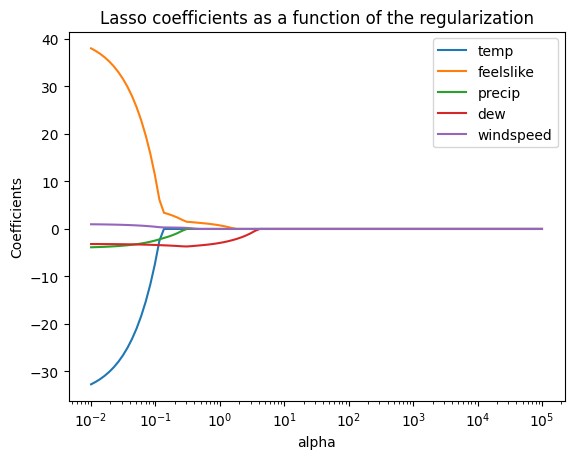

In [37]:
#PICKUP
alphas = 10**np.linspace(-2,5,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_pu), y_train_pu)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.373e-01, tolerance: 6.392e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.714e-01, tolerance: 6.392e-01
  model = cd_fast.enet_coordinate_descent(


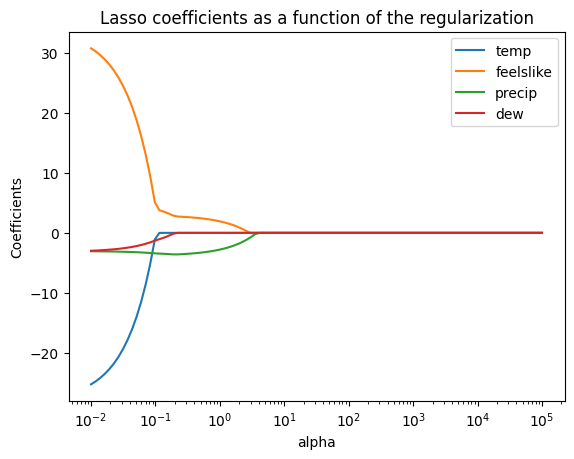

In [38]:
#DROPOFF
alphas = 10**np.linspace(-2,5,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_do), y_train_do)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

*FINDING BEST ALPHA FOR PICKUP AND DROPOFF*

In [39]:
#PICKUP
# find the best alpha via CV with selected scoring metric
lassocv_P = LassoCV(alphas=alphas)
lassocv_P.fit(scale(X_train_pu), y_train_pu)

print('The best alpha from LassoCV_P:', lassocv_P.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_train_pu), y_train_pu)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_train_pu.columns))

The best alpha from LassoCV_P: 0.01
The coefficients are:
temp        -32.708146
feelslike    38.032361
dew          -3.856502
precip       -3.167999
windspeed     0.990168
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+00, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+00, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(


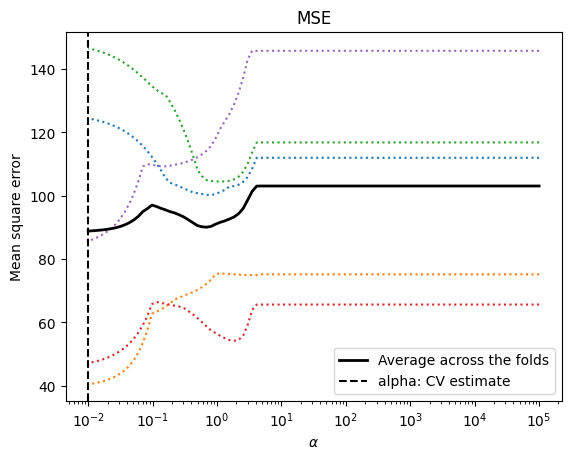

In [40]:
#PICKUP
plt.semilogx(lassocv_P.alphas_, lassocv_P.mse_path_, linestyle=":")
plt.plot(
    lassocv_P.alphas_,
    lassocv_P.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv_P.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [41]:
#PICKUP TEST
# find the best alpha via CV with selected scoring metric
lassocv_P = LassoCV(alphas=alphas)
lassocv_P.fit(scale(X_test_pu), y_test_pu)

print('The best alpha from LassoCV_P:', lassocv_P.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_test_pu), y_test_pu)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_test_pu.columns))

The best alpha from LassoCV_P: 0.022570197196339202
The coefficients are:
temp        -18.760236
feelslike    29.102891
dew          -6.155028
precip       -2.831634
windspeed     0.204409
dtype: float64


In [42]:
#PICKUP
from sklearn.metrics import mean_squared_error, r2_score

# Predict the test outcomes
y_pred_pu = lasso.predict(X_test_pu_scaled)  # Replace lasso with your actual trained Lasso model

# Calculate the MSE
lasso_mse_pu = mean_squared_error(y_test_pu, y_pred_pu)  # Replace y_test with your actual test outcomes

# Calculate the R-squared value
lasso_r2_pu = r2_score(y_test_pu, y_pred_pu)

# Print the results
print("Test MSE:", lasso_mse_pu)
print("Test R-squared:", lasso_r2_pu)


Test MSE: 63.59347834385325
Test R-squared: 0.4416672632698795


In [43]:
#DROPOFF
# find the best alpha via CV with selected scoring metric
lassocv_D = LassoCV(alphas=alphas)
lassocv_D.fit(scale(X_train_do), y_train_do)


print('The best alpha from LassoCV_D:', lassocv_D.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_D.alpha_)
lasso.fit(scale(X_train_do), y_train_do)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_train_do.columns))

The best alpha from LassoCV_D: 0.35938136638046275
The coefficients are:
temp         0.000000
feelslike    2.575973
precip      -3.441552
dew         -0.000000
dtype: float64


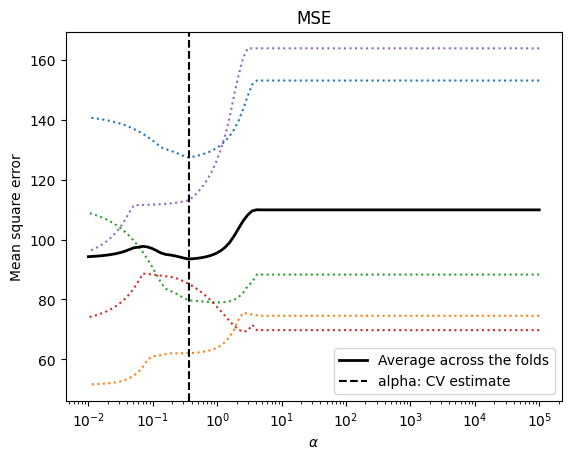

In [44]:
#DROPOFF
#PICKUP
plt.semilogx(lassocv_D.alphas_, lassocv_D.mse_path_, linestyle=":")
plt.plot(
    lassocv_D.alphas_,
    lassocv_D.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv_D.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [45]:
#DROPOFF TEST
# find the best alpha via CV with selected scoring metric
lassocv_D = LassoCV(alphas=alphas)
lassocv_D.fit(scale(X_test_do), y_test_do)

print('The best alpha from LassoCV_P:', lassocv_P.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_test_do), y_test_do)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_test_do.columns))

The best alpha from LassoCV_P: 0.022570197196339202
The coefficients are:
temp        -15.174540
feelslike    24.034591
precip       -3.067395
dew          -5.359149
dtype: float64


In [46]:
#DROPOFF
# Predict the test outcomes
y_pred_do = lasso.predict(X_test_do_scaled)  # Replace lasso with your actual trained Lasso model

# Calculate the MSE
lasso_mse_do = mean_squared_error(y_test_do, y_pred_do)  # Replace y_test with your actual test outcomes

# Calculate the R-squared value
lasso_r2_do = r2_score(y_test_do, y_pred_do)

# Print the results
print("Test MSE:", lasso_mse_do)
print("Test R-squared:", lasso_r2_do)


Test MSE: 68.55152965984627
Test R-squared: 0.37958673530970544


**ELASTIC NET**

In [47]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

In [48]:
#PICKUP
ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X_train_pu), y_train_pu)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_train_pu), y_train_pu)


EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X_train_pu), y_train_pu)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_train_pu.columns))


The best alpha from ElasticNetCV: 0.007829060226701545
The coefficients are:
temp        -15.129448
feelslike    19.703380
dew          -3.099437
precip       -3.319730
windspeed     0.692096
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.938e-01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(


In [49]:
#PICKUP
ENcv1 = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv1.fit(scale(X_test_pu), y_test_pu)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_test_pu), y_test_pu)


EN=ElasticNet()
EN.set_params(alpha=ENcv1.alpha_)
EN.fit(scale(X_test_pu), y_test_pu)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_test_pu.columns))


The best alpha from ElasticNetCV: 0.007829060226701545
The coefficients are:
temp         -7.988000
feelslike    17.858208
dew          -5.770361
precip       -2.727258
windspeed    -0.241874
dtype: float64


In [50]:
from sklearn.metrics import mean_squared_error

# Predict using the ElasticNet model
y_pred_pu = EN.predict(scale(X_test_pu))

# Calculate the Mean Squared Error
elastic_mse_pu = mean_squared_error(y_test_pu, y_pred_pu)
print("Test MSE:", elastic_mse_pu)

elastic_r2_pu = r2_score(y_test_pu, y_pred_pu)
print("Test R-squared:", elastic_r2_pu)

Test MSE: 65.62109850446886
Test R-squared: 0.42386533227304934


In [51]:
#DROPOFF
ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X_train_do), y_train_do)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_D.alpha_)
lasso.fit(scale(X_train_do), y_train_do)


EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X_train_do), y_train_do)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_train_do.columns))


The best alpha from ElasticNetCV: 0.007470653468624066
The coefficients are:
temp        -12.115978
feelslike    16.982713
precip       -3.244672
dew          -2.270785
dtype: float64


In [52]:
#DROPOFF
ENcv2 = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv2.fit(scale(X_test_do), y_test_do)

print('The best alpha from ElasticNetCV:', ENcv2.alpha_)

# with the best alpha
lasso.set_params(alpha=lassocv_P.alpha_)
lasso.fit(scale(X_test_do), y_test_do)


EN=ElasticNet()
EN.set_params(alpha=ENcv2.alpha_)
EN.fit(scale(X_test_do), y_test_do)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_test_do.columns))


The best alpha from ElasticNetCV: 0.008191024087894697
The coefficients are:
temp         -8.450701
feelslike    16.990081
precip       -3.073355
dew          -5.019633
dtype: float64


In [53]:
from sklearn.metrics import mean_squared_error

# Predict using the ElasticNet model
y_pred_do = EN.predict(scale(X_test_do))

# Calculate the Mean Squared Error
elastic_mse_do = mean_squared_error(y_test_do, y_pred_do)
print("Test MSE:", elastic_mse_do)

elastic_r2_do = r2_score(y_test_do, y_pred_do)
print("Test R-squared:", elastic_r2_do)


Test MSE: 69.65936114111386
Test R-squared: 0.3695605061441365


**KNN REGRESSOR**

In [54]:
#PICKUP
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
model = neighbors.KNeighborsRegressor(n_neighbors = 25)
model.fit(scale(X_train_pu), y_train_pu)

KNeighborsRegressor(n_neighbors=25)

In [55]:
#PICKUP
# Training MSE
print("Train MSE:",mean_squared_error(y_train_pu, model.predict(scale(X_train_pu))))

# Test MSE
print("Test MSE:",mean_squared_error(y_test_pu, model.predict(scale(X_test_pu))))

Train MSE: 95.1527733333333
Test MSE: 114.27984000000001


In [56]:
mse_train1 = [-1]*30
mse_test1 = [-1]*30

for K in range(30):
    modelk1 = neighbors.KNeighborsRegressor(n_neighbors = K+1)
    modelk1.fit(scale(X_train_pu),y_train_pu)  #fit the model
    mse_train1[K] = mean_squared_error(y_train_pu, modelk1.predict(scale(X_train_pu)))
    mse_test1[K] = mean_squared_error(y_test_pu, modelk1.predict(scale(X_test_pu)) )

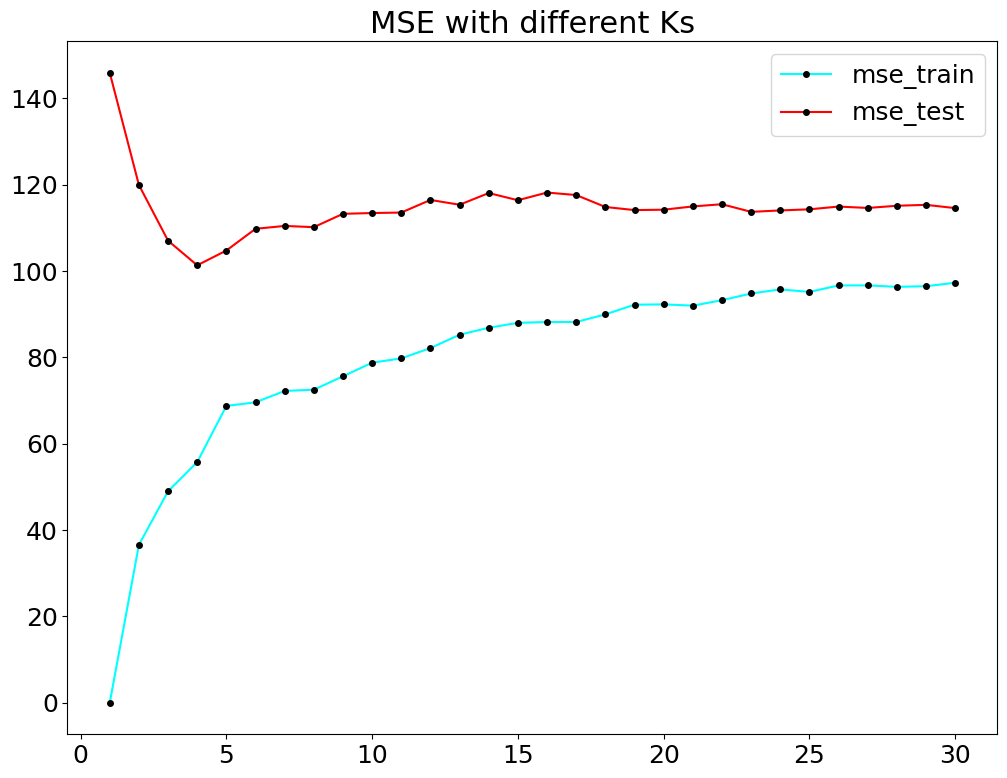

In [57]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train1,  color = 'cyan', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test1,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [58]:
# optimal k
np.argmin(mse_test1)+1

4

In [59]:
modelk1.fit(scale(X_test_pu),y_test_pu)  #fit the model
mse_train1[K] = mean_squared_error(y_train_pu, modelk1.predict(scale(X_train_pu)))
mse_test1[K] = mean_squared_error(y_test_pu, modelk1.predict(scale(X_test_pu)))
knn_r2_pu = r2_score(y_test_pu, modelk1.predict(scale(X_test_pu)))
knn_r2_pu

0.2178297623731683

In [61]:
# optimal test MSE
knn_mse_pu = min(mse_test1)
knn_mse_pu

89.08832098765433

In [62]:
#DROPOFF
model = neighbors.KNeighborsRegressor(n_neighbors = 25)
model.fit(scale(X_train_do),y_train_do)

KNeighborsRegressor(n_neighbors=25)

In [63]:
#DROPOFF
# Training MSE
print("Train MSE:",mean_squared_error(y_train_do, model.predict(scale(X_train_do))))

# Test MSE
print("Test MSE:",mean_squared_error(y_test_do, model.predict(scale(X_test_do))))

Train MSE: 97.49146666666668
Test MSE: 107.23708444444443


In [64]:
mse_train = [-1]*30
mse_test = [-1]*30

for K in range(30):
    modelk2 = neighbors.KNeighborsRegressor(n_neighbors = K+1)
    modelk2.fit(scale(X_train_do),y_train_do)  #fit the model
    mse_train[K] = mean_squared_error(y_train_do, modelk2.predict(scale(X_train_do)))
    mse_test[K] = mean_squared_error(y_test_do, modelk2.predict(scale(X_test_do) ))


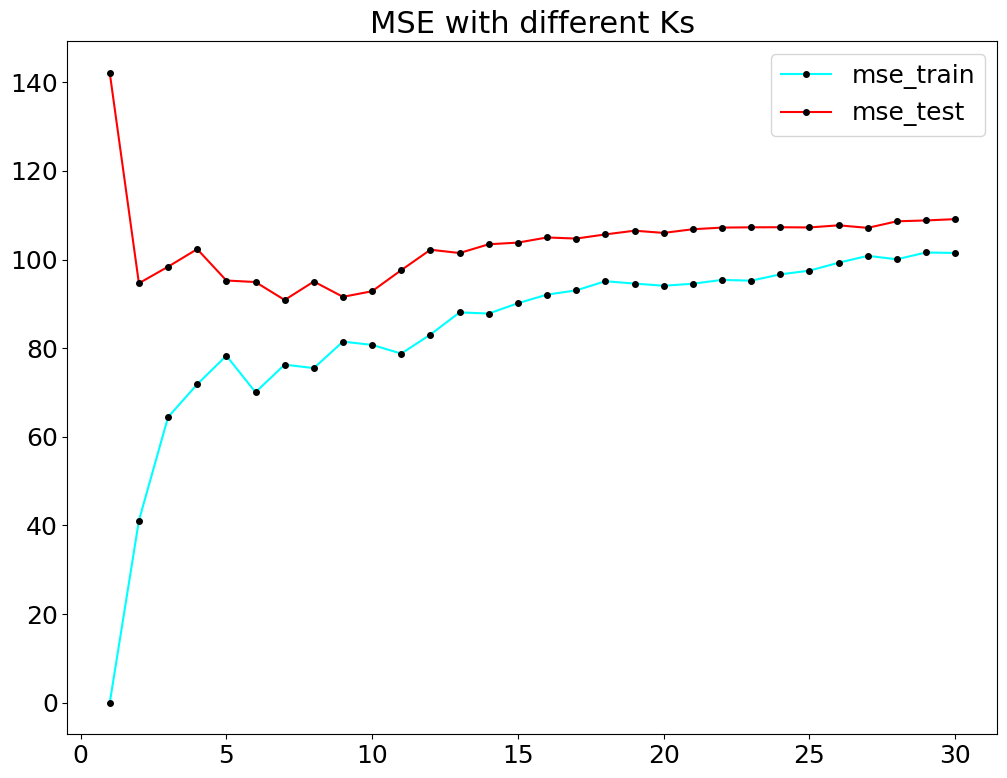

In [65]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train,  color = 'cyan', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [66]:
modelk2.fit(scale(X_test_do),y_test_do)  #fit the model
mse_train1[K] = mean_squared_error(y_train_do, modelk2.predict(scale(X_train_do)))
mse_test1[K] = mean_squared_error(y_test_do, modelk2.predict(scale(X_test_do)) )
knn_r2_do = r2_score(y_test_do, modelk2.predict(scale(X_test_do)))
knn_r2_do

0.20215129453092506

In [67]:
# optimal k
np.argmin(mse_test)+1

7

In [68]:
# optimal test MSE
knn_mse_do = min(mse_test1)
knn_mse_do

88.15696296296296

**COMPARING MSE AND R2 VALUES FOR ALL MODELS**

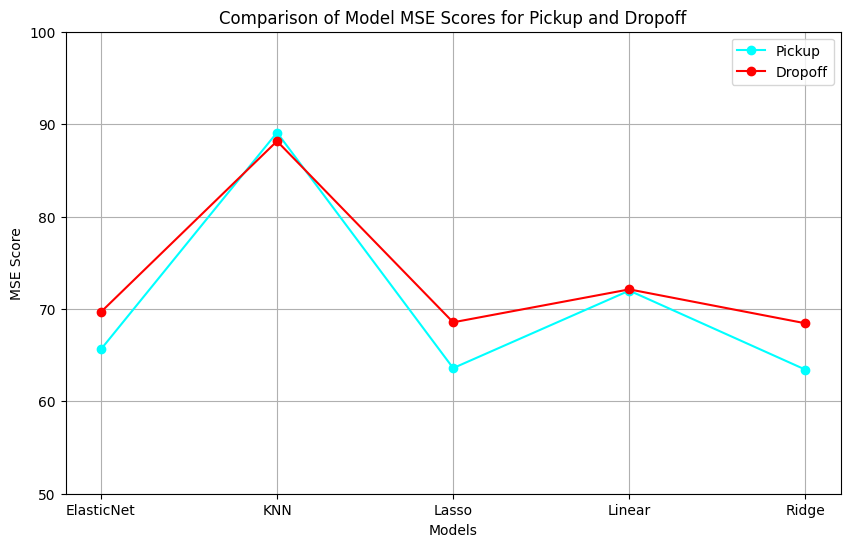

In [70]:
pickup_mse = {
    'Linear': linear_pu_mse,
    'Ridge': ridge_mse_pu,
    'Lasso': lasso_mse_pu,
    'ElasticNet': elastic_mse_pu,
    'KNN': knn_mse_pu

}

dropoff_mse = {
    'Linear': linear_do_mse,
    'Ridge': ridge_mse_do,
    'Lasso': lasso_mse_do,
    'ElasticNet': elastic_mse_do,
    'KNN': knn_mse_do
}

sorted_model_names = sorted(pickup_mse.keys())
pickup_sorted_mse = [pickup_mse[model] for model in sorted_model_names]
dropoff_sorted_mse = [dropoff_mse[model] for model in sorted_model_names]

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(sorted_model_names, pickup_sorted_mse, marker='o', linestyle='-', color='cyan', label='Pickup')
plt.plot(sorted_model_names, dropoff_sorted_mse, marker='o', linestyle='-', color='red', label='Dropoff')
plt.xlabel('Models')
plt.ylabel('MSE Score')
plt.title('Comparison of Model MSE Scores for Pickup and Dropoff')
plt.ylim(50, 100)
plt.legend()
plt.grid(True)
plt.show()

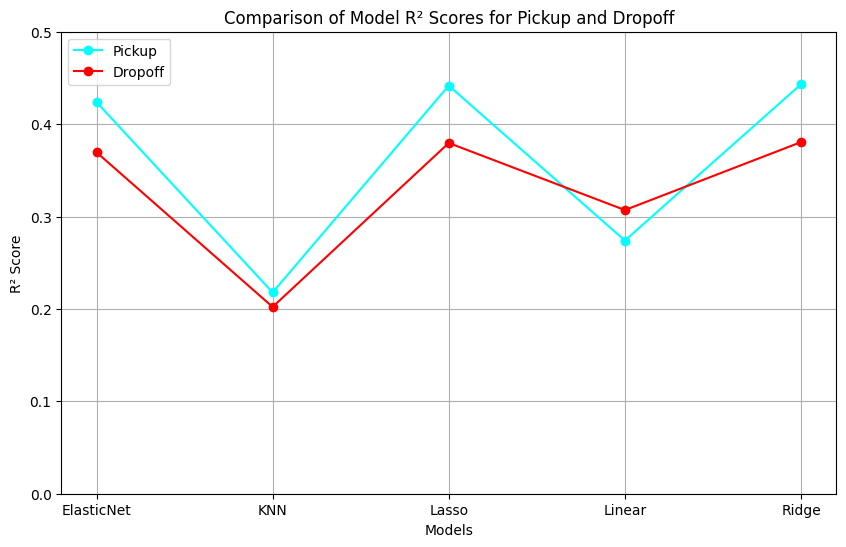

In [71]:
import matplotlib.pyplot as plt

pickup_scores = {
    'Linear': linear_r2_pu,
    'Ridge': ridge_r2_pu,
    'Lasso': lasso_r2_pu,
    'ElasticNet': elastic_r2_pu,
    'KNN': knn_r2_pu
}

dropoff_scores = {
    'Linear': linear_r2_do,
    'Ridge': ridge_r2_do,
    'Lasso': lasso_r2_do,
    'ElasticNet': elastic_r2_do,
    'KNN': knn_r2_do
}

sorted_model_names = sorted(pickup_scores.keys())
pickup_sorted_scores = [pickup_scores[model] for model in sorted_model_names]
dropoff_sorted_scores = [dropoff_scores[model] for model in sorted_model_names]

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(sorted_model_names, pickup_sorted_scores, marker='o', linestyle='-', color='cyan', label='Pickup')
plt.plot(sorted_model_names, dropoff_sorted_scores, marker='o', linestyle='-', color='red', label='Dropoff')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of Model R² Scores for Pickup and Dropoff')
plt.ylim(0.0, 0.5)
plt.legend()
plt.grid(True)
plt.show()



---

**TOTAL COST COMPARISION FOR ALL MODELS**

In [72]:
# Constants based on your business strategy
alpha = 2  # Penalty for each unsuccessful pickup
beta = 3   # Penalty for each unsuccessful drop-off


# Predict using your trained Linear models
y_pred_pu_ct = model_pu.predict(X_test[['temp', 'feelslike','dew','precip','windspeed']])
y_pred_do_ct = model_do.predict(X_test[['temp', 'feelslike','precip', 'dew']])

# Initialize variable to track the maximum combined cost per instance
max_combined_cost = 0

total_costs = []  # Initialize list to keep track of total costs

# Go through each prediction and actual values to calculate and track costs
for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]


    # Calculate individual costs for pickups and drop-offs correctly
    pu_cost = alpha * max(0, predicted_pu - 10)
    do_cost = beta * max(0, predicted_do - 7)

    combined_cost = pu_cost + do_cost
    total_costs.append(combined_cost)  # Summing the total cost for later averaging

# Update maximum combined cost
max_cost_linear = max(0, combined_cost)

# Calculate the average total cost from all total costs
average_cost_linear = sum(total_costs) / len(total_costs)

# Print the maximum combined cost and average total cost
print("Maximum combined cost per instance:", max_cost_linear)
print("Average total cost:", average_cost_linear)

Maximum combined cost per instance: 91.40782479164545
Average total cost: 95.82893058907933


In [73]:
# Constants based on your business strategy
alpha = 2  # Penalty for each unsuccessful pickup
beta = 3   # Penalty for each unsuccessful drop-off


# Predict using your trained Ridge models
y_pred_pu_ct = ridgecv1.predict(scale(X_test_pu))
y_pred_do_ct = ridgecv2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_cost = 0

total_costs = []  # Initialize list to keep track of total costs

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]


    # Calculate individual costs for pickups and drop-offs correctly
    pu_cost = alpha * max(0, predicted_pu - 10)
    do_cost = beta * max(0, predicted_do - 7)

    combined_cost = pu_cost + do_cost
    total_costs.append(combined_cost)  # Summing the total cost for later averaging

# Update maximum combined cost
max_cost_ridge = max(0, combined_cost)

# Calculate the average total cost from all total costs
average_cost_ridge = sum(total_costs) / len(total_costs)

# Print the maximum combined cost and average total cost
print("Maximum combined cost per instance:", max_cost_ridge)
print("Average total cost:", average_cost_ridge)

Maximum combined cost per instance: 91.85958023323059
Average total cost: 96.52337053216631


In [74]:
# Constants based on your business strategy
alpha = 2  # Penalty for each unsuccessful pickup
beta = 3   # Penalty for each unsuccessful drop-off


# Predict using your trained Lasso models
y_pred_pu_ct = lassocv_P.predict(scale(X_test_pu))
y_pred_do_ct = lassocv_D.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_cost = 0

total_costs = []  # Initialize list to keep track of total costs

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]


    # Calculate individual costs for pickups and drop-offs correctly
    pu_cost = alpha * max(0, predicted_pu - 10)
    do_cost = beta * max(0, predicted_do - 7)

    combined_cost = pu_cost + do_cost
    total_costs.append(combined_cost)  # Summing the total cost for later averaging

# Update maximum combined cost
max_cost_lasso = max(0, combined_cost)

# Calculate the average total cost from all total costs
average_cost_lasso = sum(total_costs) / len(total_costs)

# Print the maximum combined cost and average total cost
print("Maximum combined cost per instance:", max_cost_lasso)
print("Average total cost:", average_cost_lasso)

Maximum combined cost per instance: 85.8010659268214
Average total cost: 91.46800707195695


In [75]:
# Constants based on your business strategy
alpha = 2  # Penalty for each unsuccessful pickup
beta = 3   # Penalty for each unsuccessful drop-off


# Predict using your trained ElasticNet models
y_pred_pu_ct = ENcv1.predict(scale(X_test_pu))
y_pred_do_ct = ENcv2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_cost = 0

total_costs = []  # Initialize list to keep track of total costs

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]


    # Calculate individual costs for pickups and drop-offs correctly
    pu_cost = alpha * max(0, predicted_pu - 10)
    do_cost = beta * max(0, predicted_do - 7)

    combined_cost = pu_cost + do_cost
    total_costs.append(combined_cost)  # Summing the total cost for later averaging

# Update maximum combined cost
max_cost_EN = max(0, combined_cost)

# Calculate the average total cost from all total costs
average_cost_EN = sum(total_costs) / len(total_costs)

# Print the maximum combined cost and average total cost
print("Maximum combined cost per instance:", max_cost_EN)
print("Average total cost:", average_cost_EN)

Maximum combined cost per instance: 86.3603099870459
Average total cost: 91.40952379458744


In [76]:
# Constants based on your business strategy
alpha = 2  # Penalty for each unsuccessful pickup
beta = 3   # Penalty for each unsuccessful drop-off


# Predict using your trained KNN models
y_pred_pu_ct = modelk1.predict(scale(X_test_pu))
y_pred_do_ct = modelk2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_cost = 0

total_costs = []  # Initialize list to keep track of total costs

for i in range(len(y_test)):
    actual_pu = y_test_pu.iloc[i]
    actual_do = y_test_do.iloc[i]
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]


    # Calculate individual costs for pickups and drop-offs correctly
    pu_cost = alpha * max(0, predicted_pu - 10)
    do_cost = beta * max(0, predicted_do - 7)

    combined_cost = pu_cost + do_cost
    total_costs.append(combined_cost)  # Summing the total cost for later averaging

# Update maximum combined cost
max_cost_KNN = max(0, combined_cost)

# Calculate the average total cost from all total costs
average_cost_KNN = sum(total_costs) / len(total_costs)

# Print the maximum combined cost and average total cost
print("Maximum combined cost per instance:", max_cost_KNN)
print("Average total cost:", average_cost_KNN)

Maximum combined cost per instance: 110.26666666666667
Average total cost: 99.35333333333332


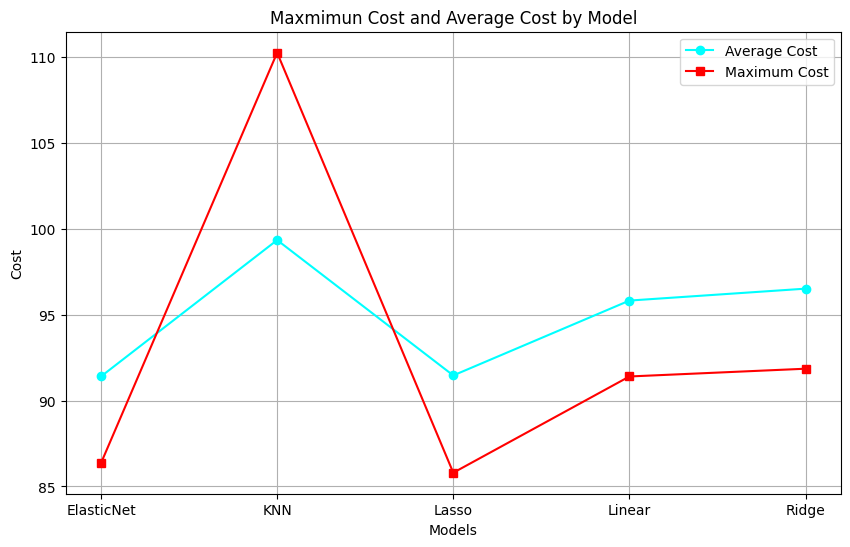

In [77]:
average_costs = {
    'Linear': average_cost_linear.item(),
    'Ridge': average_cost_ridge,
    'Lasso': average_cost_lasso,
    'ElasticNet': average_cost_EN,
    'KNN': average_cost_KNN
}
sorted_model_names = sorted(average_costs.keys())
sorted_costs = [average_costs[model] for model in sorted_model_names]

max_combined_cost = {
    'Linear': max_cost_linear.item(),
    'Ridge': max_cost_ridge,
    'Lasso': max_cost_lasso,
    'ElasticNet': max_cost_EN,
    'KNN': max_cost_KNN
}
sorted_max_combined_cost = [max_combined_cost[model] for model in sorted_model_names]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_model_names, sorted_costs, marker='o', linestyle='-', color='cyan', label='Average Cost')
plt.plot(sorted_model_names, sorted_max_combined_cost, marker='s', linestyle='-', color='red', label='Maximum Cost')
plt.xlabel('Models')
plt.ylabel('Cost')
plt.title('Maxmimun Cost and Average Cost by Model')
plt.grid(True)
plt.legend()
plt.show()

**SERVICE AVAILABILITY COMPARISION FOR ALL MODELS**

In [78]:
# Constants based on your business strategy
alpha = 0.5  # Penalty for each unsuccessful pickup
beta = 0.5   # Penalty for each unsuccessful drop-off


# Predict using your trained Linear models
y_pred_pu_ct = model_pu.predict(X_test[['temp', 'feelslike','dew','precip','windspeed']])
y_pred_do_ct = model_do.predict(X_test[['temp', 'feelslike','precip', 'dew']])

# Initialize variable to track the maximum combined cost per instance
max_combined_qt = 0

total_qt = []  # Initialize list to keep track of total quantity

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]

    predicted_pu = max(1, predicted_pu)
    predicted_do = max(1, predicted_do)


    # Calculate individual quantity for pickups and drop-offs correctly
    pu_qt = alpha * min(10, predicted_pu)/predicted_pu
    do_qt = beta * min(7, predicted_do)/predicted_do

    combined_qt = pu_qt + do_qt
    total_qt.append(combined_qt)

# Update maximum combined quantity
max_qt_linear = max(total_qt)

# Calculate the average total cost from all total quantity
average_qt_linear = sum(total_qt) / len(total_qt)

# Print the maximum combined quantity and average total quantity
print("Maximum quality of service:", max_qt_linear)
print("Average quality of service:", average_qt_linear)

Maximum quality of service: 0.9799604146369896
Average quality of service: 0.3374033344838428


In [79]:
# Constants based on your business strategy
alpha = 0.5  # Penalty for each unsuccessful pickup
beta = 0.5   # Penalty for each unsuccessful drop-off


# Predict using your trained Ridge models
y_pred_pu_ct = ridgecv1.predict(scale(X_test_pu))
y_pred_do_ct = ridgecv2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_qt = 0

total_qt = []  # Initialize list to keep track of total quantity

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]

    predicted_pu = max(1, predicted_pu)
    predicted_do = max(1, predicted_do)


    # Calculate individual quantity for pickups and drop-offs correctly
    pu_qt = alpha * min(10, predicted_pu)/predicted_pu
    do_qt = beta * min(7, predicted_do)/predicted_do

    combined_qt = pu_qt + do_qt
    total_qt.append(combined_qt)

# Update maximum combined quantity
max_qt_ridge = max(total_qt)

# Calculate the average total cost from all total quantity
average_qt_ridge = sum(total_qt) / len(total_qt)

# Print the maximum combined quantity and average total quantity
print("Maximum quality of service:", max_qt_ridge)
print("Average quality of service:", average_qt_ridge)

Maximum quality of service: 0.9300637443194645
Average quality of service: 0.3436825842508952


In [80]:
# Constants based on your business strategy
alpha = 0.5  # Penalty for each unsuccessful pickup
beta = 0.5   # Penalty for each unsuccessful drop-off


# Predict using your trained Lasso models
y_pred_pu_ct = lassocv_P.predict(scale(X_test_pu))
y_pred_do_ct = lassocv_D.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_qt = 0

total_qt = []  # Initialize list to keep track of total quantity

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]

    predicted_pu = max(1, predicted_pu)
    predicted_do = max(1, predicted_do)


    # Calculate individual quantity for pickups and drop-offs correctly
    pu_qt = alpha * min(10, predicted_pu)/predicted_pu
    do_qt = beta * min(7, predicted_do)/predicted_do

    combined_qt = pu_qt + do_qt
    total_qt.append(combined_qt)

# Update maximum combined quantity
max_qt_lasso = max(total_qt)

# Calculate the average total cost from all total quantity
average_qt_lasso = sum(total_qt) / len(total_qt)

# Print the maximum combined quantity and average total quantity
print("Maximum quality of service:", max_qt_lasso)
print("Average quality of service:", average_qt_lasso)

Maximum quality of service: 1.0
Average quality of service: 0.3555247249500727


In [81]:
# Constants based on your business strategy
alpha = 0.5  # Penalty for each unsuccessful pickup
beta = 0.5   # Penalty for each unsuccessful drop-off


# Predict using your trained ElasticNet models
y_pred_pu_ct = ENcv1.predict(scale(X_test_pu))
y_pred_do_ct = ENcv2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_qt = 0

total_qt = []  # Initialize list to keep track of total quantity

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]

    predicted_pu = max(1, predicted_pu)
    predicted_do = max(1, predicted_do)


    # Calculate individual quantity for pickups and drop-offs correctly
    pu_qt = alpha * min(10, predicted_pu)/predicted_pu
    do_qt = beta * min(7, predicted_do)/predicted_do

    combined_qt = pu_qt + do_qt
    total_qt.append(combined_qt)

# Update maximum combined quantity
max_qt_EN = max(total_qt)

# Calculate the average total cost from all total quantity
average_qt_EN = sum(total_qt) / len(total_qt)

# Print the maximum combined quantity and average total quantity
print("Maximum quality of service:", max_qt_EN)
print("Average quality of service:", average_qt_EN)

Maximum quality of service: 1.0
Average quality of service: 0.3518616901004198


In [82]:
# Constants based on your business strategy
alpha = 0.5  # Penalty for each unsuccessful pickup
beta = 0.5   # Penalty for each unsuccessful drop-off


# Predict using your trained KNN models
y_pred_pu_ct = modelk1.predict(scale(X_test_pu))
y_pred_do_ct = modelk2.predict(scale(X_test_do))

# Initialize variable to track the maximum combined cost per instance
max_combined_qt = 0

total_qt = []  # Initialize list to keep track of total quantity

for i in range(len(y_test)):
    predicted_pu = y_pred_pu_ct[i]
    predicted_do = y_pred_do_ct[i]

    predicted_pu = max(1, predicted_pu)
    predicted_do = max(1, predicted_do)


    # Calculate individual quantity for pickups and drop-offs correctly
    pu_qt = alpha * min(predicted_pu, 10)/predicted_pu
    do_qt = beta * min(predicted_do, 7)/predicted_do

    combined_qt = pu_qt + do_qt
    total_qt.append(combined_qt)

# Update maximum combined quantity
max_qt_KNN = max(total_qt)

# Calculate the average total cost from all total quantity
average_qt_KNN = sum(total_qt) / len(total_qt)

# Print the maximum combined quantity and average total quantity
print("Maximum quality of service:", max_qt_KNN)
print("Average quality of service:", average_qt_KNN)

Maximum quality of service: 0.43067672424547365
Average quality of service: 0.30982449259717215


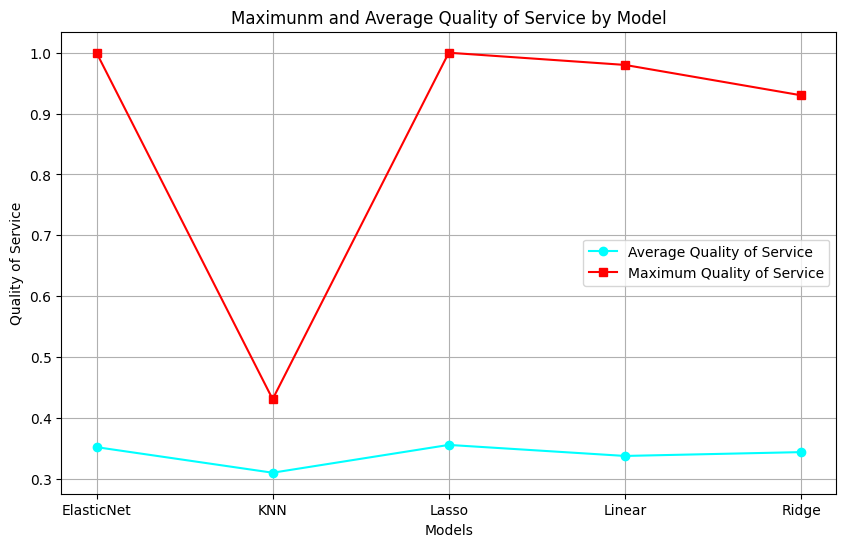

In [83]:
average_quality_of_service = {
    'Linear': average_qt_linear.item(),
    'Ridge': average_qt_ridge,
    'Lasso': average_qt_lasso,
    'ElasticNet': average_qt_EN,
    'KNN': average_qt_KNN
}
sorted_model_names = sorted(average_quality_of_service.keys())
sorted_avg_quality = [average_quality_of_service[model] for model in sorted_model_names]

maxmimum_quality_of_service = {
    'Linear': max_qt_linear.item(),
    'Ridge': max_qt_ridge,
    'Lasso': max_qt_lasso,
    'ElasticNet': max_qt_EN,
    'KNN': max_qt_KNN
}
sorted_max_quality = [maxmimum_quality_of_service[model] for model in sorted_model_names]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_model_names, sorted_avg_quality, marker='o', linestyle='-', color='cyan', label='Average Quality of Service')
plt.plot(sorted_model_names, sorted_max_quality, marker='s', linestyle='-', color='red', label='Maximum Quality of Service')
plt.xlabel('Models')
plt.ylabel('Quality of Service')
plt.title('Maximunm and Average Quality of Service by Model')
plt.grid(True)
plt.legend()
plt.show()